# Setup enviorment

In [ ]:
%cd ..

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_224_1024.csv'
embeddings_dir = 'Embeddings/'

labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043    2044  \
41001 201546 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201547 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201548 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201549 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201550 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.918507  -1.0 -0.861740  
      201547  -1.0 -0.918507  -1.0 -0.854589  
      201548  -1.0 -0.918507  -1.0 -0.856973  
      201549  -1.0 -0.918507  -1.0 -0.856973  
      201550  -1.0 -0.918507  -1.0 -0.823600  

[5 rows x 2049 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5         6    7  \
5360 201546 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   
     201547 -1.0 -1.000000 -0.420975 -1.000000 -1.000000 -1.0 -1.000000 -1.0   
     201548 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   
     201549 -1.0 -0.988155 -0.337508 -1.000000 -0.844715 -1.0 -0.998583 -1.0   
     201550 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   

               8         9  ...     2039      2040      2041  2042      2043  \
5360 201546 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   
     201547 -1.0 -1.000000  ... -0.86945 -0.774895 -1.000000  -1.0 -0.918301   
     201548 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   
     201549 -1.0 -0.662333  ... -1.00000 -0.762259 -1.000000  -1.0 -0.977865   
     201550 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   

               2044  2045      2046  2047    Labels  
5360 201546 -0.5034  -1.0 -0.918507  -1.0 -0.990465  
     201547 -1.0000  -1.0 -0.848083  -1.0 -0.969011  
     201548 -0.5034  -1.0 -0.918507  -1.0 -0.995232  
     201549 -1.0000  -1.0 -0.879277  -1.0 -0.997616  
     201550 -0.5034  -1.0 -0.918507  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

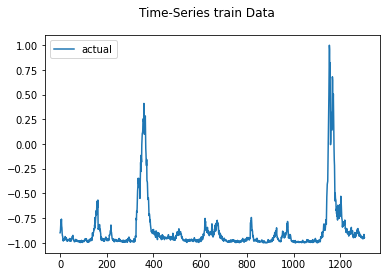

2023-03-06 16:28:43.680958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 16:28:43.681005: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 16:28:43.681030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 16:28:43.681244: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:28:43.858775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 51.484
Test RMSE: 64.576
Test sMAPE: 136.570
Test R Squared: -2.838
{'mae': 51.48424864254115, 'rmse': 64.57562862726897, 'smape': 136.57034095358435, 'r2': -2.8381655357725424}


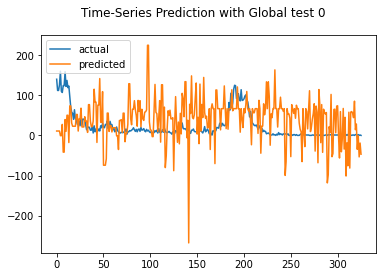

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 48.376
Test RMSE: 61.639
Test sMAPE: 139.743
Test R Squared: -2.497
{'mae': 48.375848133596904, 'rmse': 61.63877033659216, 'smape': 139.7425045680219, 'r2': -2.4969896630269135}


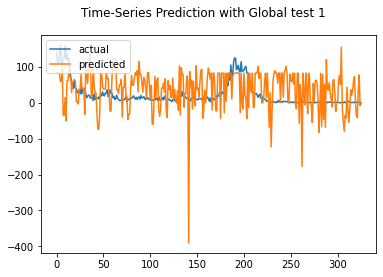

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 66.602
Test RMSE: 83.849
Test sMAPE: 137.552
Test R Squared: -5.471
{'mae': 66.60173598462087, 'rmse': 83.8486604799012, 'smape': 137.5523894113812, 'r2': -5.471108387978789}


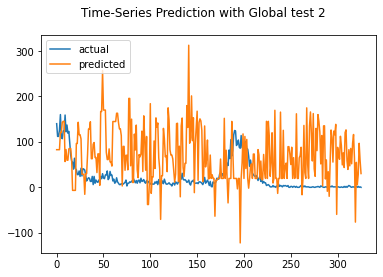

Test MAE: 71.942
Test RMSE: 97.948
Test sMAPE: 144.120
Test R Squared: -7.830
{'mae': 71.94173554518471, 'rmse': 97.94754802501004, 'smape': 144.1200852497138, 'r2': -7.830261261790133}


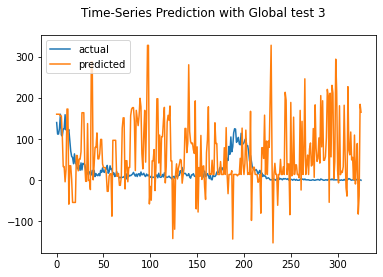

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 56.429
Test RMSE: 72.629
Test sMAPE: 147.635
Test R Squared: -3.855
{'mae': 56.42931962634888, 'rmse': 72.62867691330871, 'smape': 147.63481959441003, 'r2': -3.855150329596345}


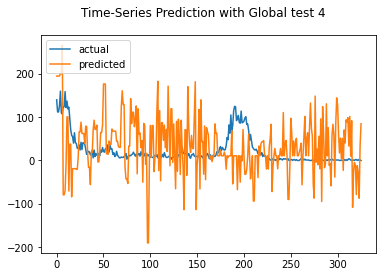

Test MAE: 54.783
Test RMSE: 64.964
Test sMAPE: 134.778
Test R Squared: -2.884
{'mae': 54.78329174705078, 'rmse': 64.9640447929943, 'smape': 134.77772505938864, 'r2': -2.884476786572264}


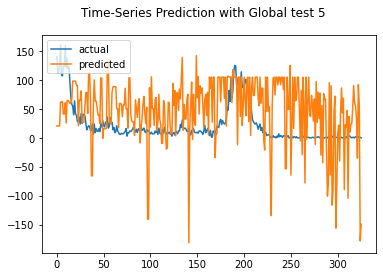

Test MAE: 64.587
Test RMSE: 96.458
Test sMAPE: 147.018
Test R Squared: -7.564
{'mae': 64.58730946435519, 'rmse': 96.45838495674485, 'smape': 147.01759503852637, 'r2': -7.563797479549121}


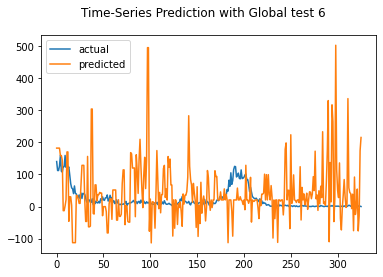

Test MAE: 77.470
Test RMSE: 89.605
Test sMAPE: 151.255
Test R Squared: -6.390
{'mae': 77.46981828307813, 'rmse': 89.60541615753372, 'smape': 151.25461178023963, 'r2': -6.390178674376207}


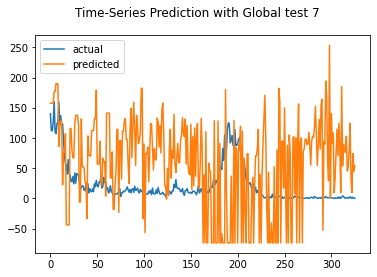

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 57.226
Test RMSE: 67.160
Test sMAPE: 138.649
Test R Squared: -3.151
{'mae': 57.2262729487719, 'rmse': 67.15973989021556, 'smape': 138.648696110185, 'r2': -3.1514941196349637}


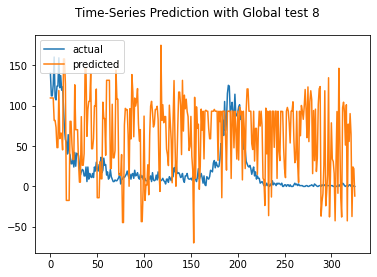

Test MAE: 54.566
Test RMSE: 62.221
Test sMAPE: 144.314
Test R Squared: -2.563
{'mae': 54.56622046780733, 'rmse': 62.22079527703615, 'smape': 144.31385024134823, 'r2': -2.5633422047652834}


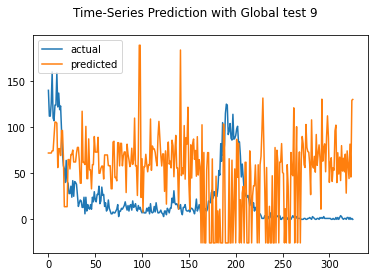

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 45.433
Test RMSE: 55.282
Test sMAPE: 127.968
Test R Squared: -1.813
{'mae': 45.433193804296245, 'rmse': 55.282157370458584, 'smape': 127.96753878113753, 'r2': -1.8129135302998458}


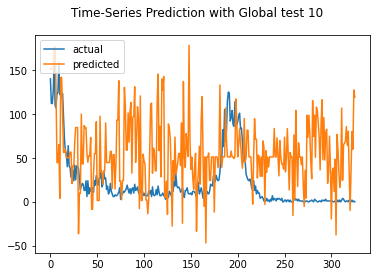

Test MAE: 57.381
Test RMSE: 73.516
Test sMAPE: 137.623
Test R Squared: -3.975
{'mae': 57.380892045384535, 'rmse': 73.51647625635857, 'smape': 137.62335112126007, 'r2': -3.974572690405221}


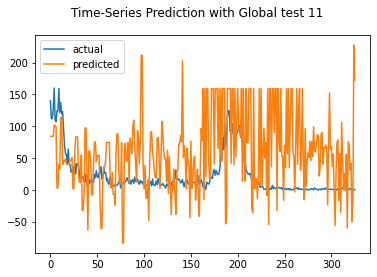

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 58.259
Test RMSE: 72.966
Test sMAPE: 137.069
Test R Squared: -3.900
{'mae': 58.25941604778079, 'rmse': 72.96637235560172, 'smape': 137.0690148406285, 'r2': -3.900404459914828}


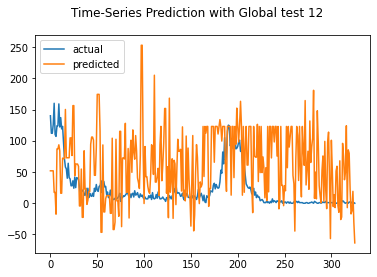

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 55.508
Test RMSE: 69.065
Test sMAPE: 137.025
Test R Squared: -3.390
{'mae': 55.50779279225443, 'rmse': 69.06499974214451, 'smape': 137.02516746775112, 'r2': -3.390383376100469}


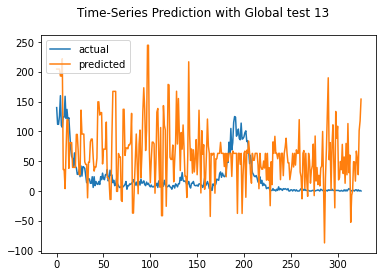

Test MAE: 112.001
Test RMSE: 140.078
Test sMAPE: 155.996
Test R Squared: -17.060
{'mae': 112.00131871802675, 'rmse': 140.07769591109556, 'smape': 155.99620363935975, 'r2': -17.060276514863286}


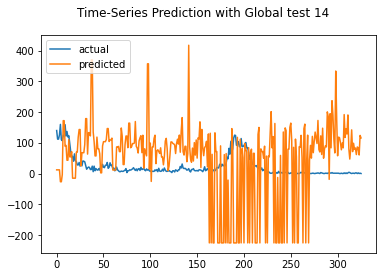

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 55.390
Test RMSE: 65.963
Test sMAPE: 129.547
Test R Squared: -3.005
{'mae': 55.39043217394615, 'rmse': 65.96347029281625, 'smape': 129.54726466038525, 'r2': -3.0049159603632933}


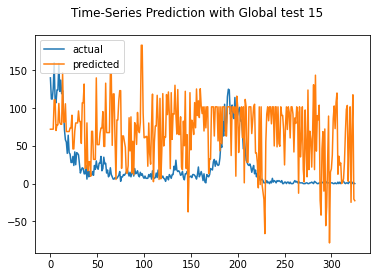

Test MAE: 66.336
Test RMSE: 84.305
Test sMAPE: 143.494
Test R Squared: -5.542
{'mae': 66.33581642980225, 'rmse': 84.30505572436192, 'smape': 143.49383597202683, 'r2': -5.541745672649286}


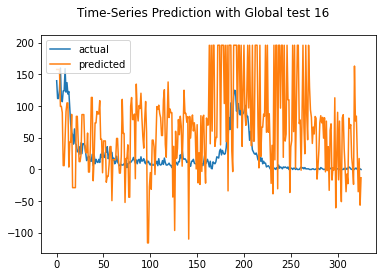

Test MAE: 100.677
Test RMSE: 135.907
Test sMAPE: 159.694
Test R Squared: -16.001
{'mae': 100.67740547327908, 'rmse': 135.90702768561053, 'smape': 159.69363200138295, 'r2': -16.000834716993175}


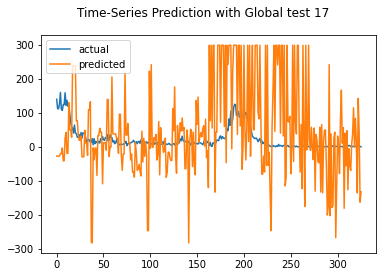

Test MAE: 105.692
Test RMSE: 120.633
Test sMAPE: 180.634
Test R Squared: -12.394
{'mae': 105.69246475169994, 'rmse': 120.632714846916, 'smape': 180.63390943390976, 'r2': -12.3941950735851}


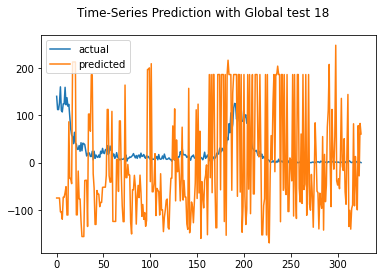

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 49.464
Test RMSE: 62.843
Test sMAPE: 136.455
Test R Squared: -2.635
{'mae': 49.4635260296197, 'rmse': 62.8425379933456, 'smape': 136.4546488419689, 'r2': -2.6349115628597644}


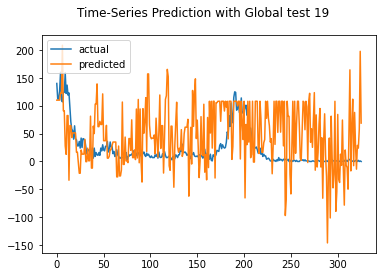

Test MAE: 101.016
Test RMSE: 128.447
Test sMAPE: 149.993
Test R Squared: -14.186
{'mae': 101.015742388971, 'rmse': 128.4473543964031, 'smape': 149.99337794432068, 'r2': -14.185767397875239}


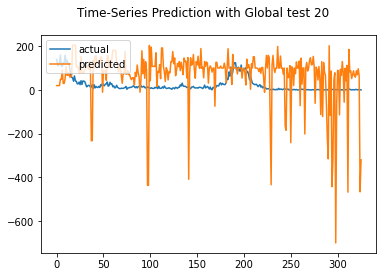

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 52.105
Test RMSE: 62.276
Test sMAPE: 138.829
Test R Squared: -2.570
{'mae': 52.10488466589363, 'rmse': 62.27639204841913, 'smape': 138.82881273582402, 'r2': -2.5697130275998954}


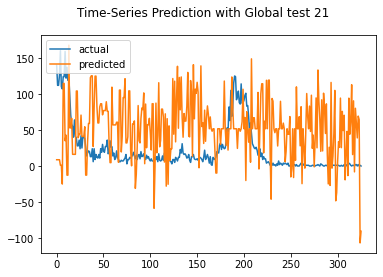

Test MAE: 71.044
Test RMSE: 81.150
Test sMAPE: 140.662
Test R Squared: -5.061
{'mae': 71.04385666101257, 'rmse': 81.15021993049918, 'smape': 140.66158171192163, 'r2': -5.061300542953556}


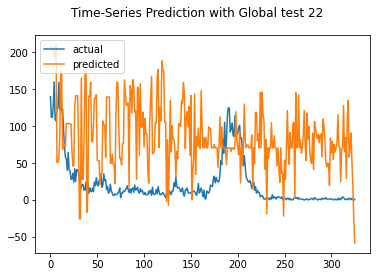

Test MAE: 48.177
Test RMSE: 55.217
Test sMAPE: 131.100
Test R Squared: -1.806
{'mae': 48.17690813248874, 'rmse': 55.21747435599018, 'smape': 131.09982310455607, 'r2': -1.8063348694424661}


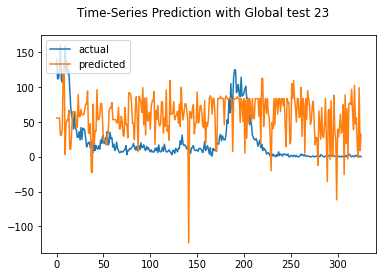

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 46.149
Test RMSE: 57.644
Test sMAPE: 129.997
Test R Squared: -2.058
{'mae': 46.14912013097043, 'rmse': 57.64436722722597, 'smape': 129.99684481941998, 'r2': -2.0584414341662702}


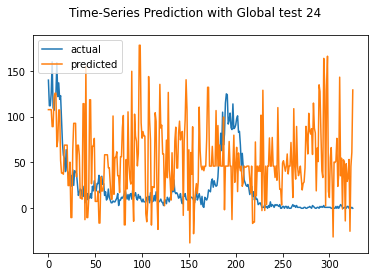

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 49.145
Test RMSE: 56.657
Test sMAPE: 130.425
Test R Squared: -1.955
{'mae': 49.144663703222214, 'rmse': 56.65739368413958, 'smape': 130.42462527477022, 'r2': -1.9546061756716657}


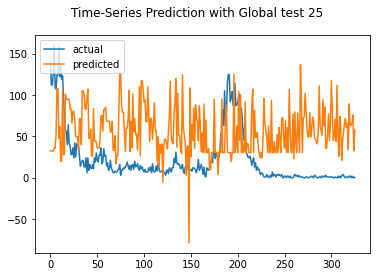

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 56.535
Test RMSE: 68.523
Test sMAPE: 137.947
Test R Squared: -3.322
{'mae': 56.53530439131099, 'rmse': 68.52300995015695, 'smape': 137.9469544755915, 'r2': -3.321746404787734}


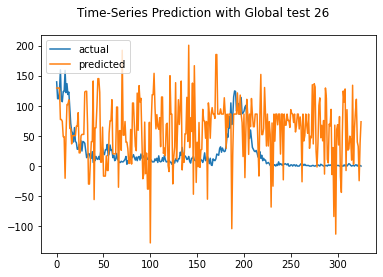

Test MAE: 68.661
Test RMSE: 81.213
Test sMAPE: 139.989
Test R Squared: -5.071
{'mae': 68.66081427979323, 'rmse': 81.21255921903331, 'smape': 139.988862669497, 'r2': -5.070616655663461}


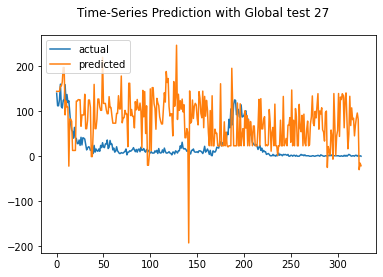

Test MAE: 88.720
Test RMSE: 99.287
Test sMAPE: 155.280
Test R Squared: -8.073
{'mae': 88.7196166559231, 'rmse': 99.28659997763846, 'smape': 155.2796146184582, 'r2': -8.073350622636132}


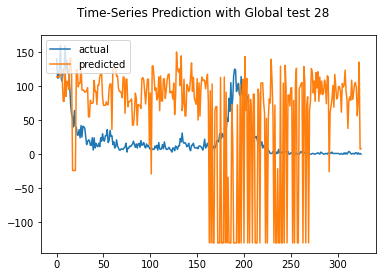

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 32.591
Test RMSE: 44.002
Test sMAPE: 130.684
Test R Squared: -0.782
{'mae': 32.591224517558985, 'rmse': 44.00198134353198, 'smape': 130.6844468154919, 'r2': -0.7820951215554841}


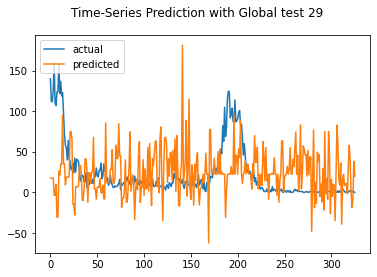

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 61.077
Test RMSE: 80.294
Test sMAPE: 153.483
Test R Squared: -4.934
{'mae': 61.077269386842936, 'rmse': 80.29404227166434, 'smape': 153.48336458173463, 'r2': -4.934075407490008}


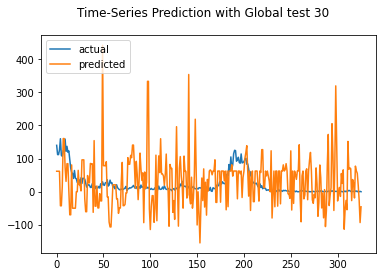

Test MAE: 71.798
Test RMSE: 105.888
Test sMAPE: 140.533
Test R Squared: -9.320
{'mae': 71.79786983278632, 'rmse': 105.88758971336496, 'smape': 140.5331295279313, 'r2': -9.319925013189032}


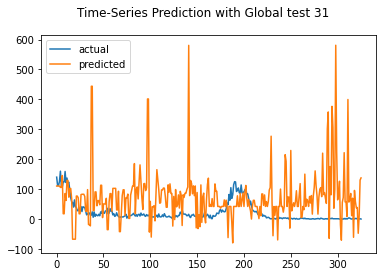

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 51.358
Test RMSE: 67.091
Test sMAPE: 149.319
Test R Squared: -3.143
{'mae': 51.35837576433193, 'rmse': 67.09092159998677, 'smape': 149.3192325243957, 'r2': -3.142990443159741}


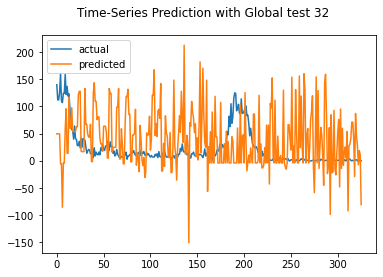

Test MAE: 45.302
Test RMSE: 52.047
Test sMAPE: 128.959
Test R Squared: -1.493
{'mae': 45.302285464994746, 'rmse': 52.04670631610758, 'smape': 128.95896380769685, 'r2': -1.4932907081335371}


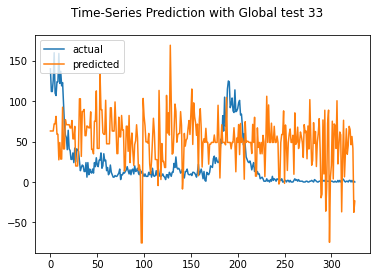

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 49.621
Test RMSE: 59.489
Test sMAPE: 134.960
Test R Squared: -2.257
{'mae': 49.621356028903485, 'rmse': 59.488528426697215, 'smape': 134.9597685447069, 'r2': -2.2572633142591765}


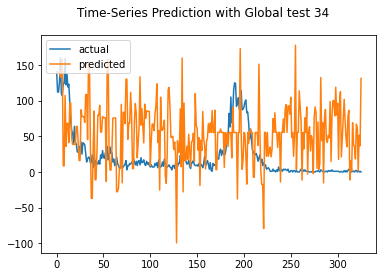

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.541
Test RMSE: 49.732
Test sMAPE: 125.869
Test R Squared: -1.276
{'mae': 40.54058855196084, 'rmse': 49.732464712937755, 'smape': 125.86924562030714, 'r2': -1.2764933317665128}


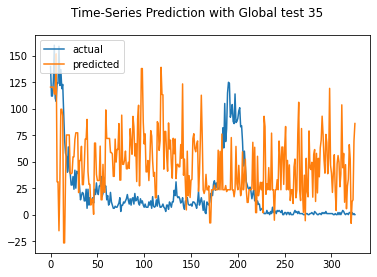

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 51.337
Test RMSE: 64.919
Test sMAPE: 149.589
Test R Squared: -2.879
{'mae': 51.33710830992351, 'rmse': 64.918883616617, 'smape': 149.58949706801027, 'r2': -2.879077905831235}


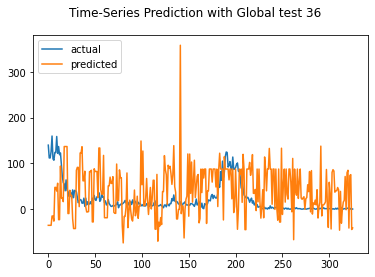

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.827
Test RMSE: 57.432
Test sMAPE: 132.145
Test R Squared: -2.036
{'mae': 49.82703397902974, 'rmse': 57.43214274752621, 'smape': 132.1452739011859, 'r2': -2.0359628695342855}


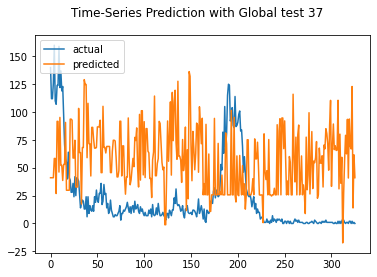

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 48.167
Test RMSE: 59.533
Test sMAPE: 137.912
Test R Squared: -2.262
{'mae': 48.16691731629562, 'rmse': 59.53278542961917, 'smape': 137.91232561927558, 'r2': -2.2621116552467333}


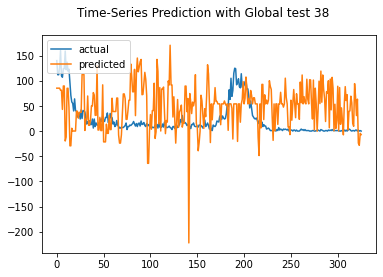

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 52.359
Test RMSE: 65.975
Test sMAPE: 135.402
Test R Squared: -3.006
{'mae': 52.35928752954386, 'rmse': 65.97486468304834, 'smape': 135.40224691476922, 'r2': -3.0062996812748857}


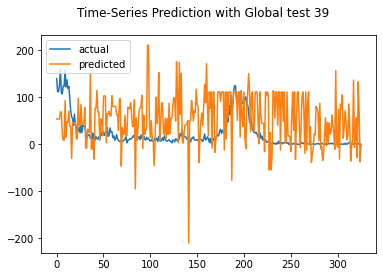

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 57.004
Test RMSE: 66.024
Test sMAPE: 136.372
Test R Squared: -3.012
{'mae': 57.00351305278532, 'rmse': 66.02367039281816, 'smape': 136.37156911584714, 'r2': -3.012229291692287}


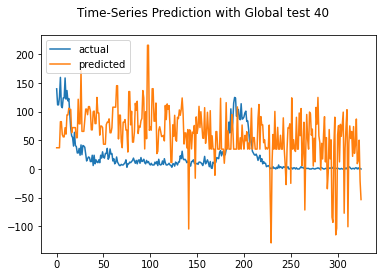

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 39.618
Test RMSE: 48.942
Test sMAPE: 134.481
Test R Squared: -1.205
{'mae': 39.6178409463606, 'rmse': 48.94214557713342, 'smape': 134.48069260150618, 'r2': -1.2047148391667504}


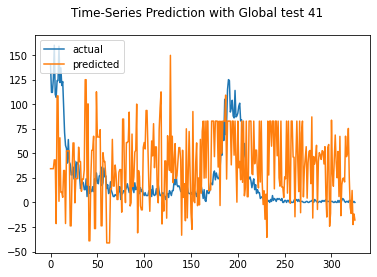

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 51.535
Test RMSE: 65.591
Test sMAPE: 133.906
Test R Squared: -2.960
{'mae': 51.535382597450095, 'rmse': 65.59080229038919, 'smape': 133.90608419393772, 'r2': -2.959791348513364}


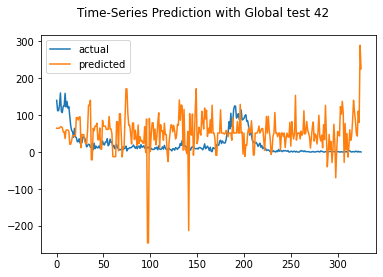

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 54.964
Test RMSE: 68.843
Test sMAPE: 141.270
Test R Squared: -3.362
{'mae': 54.96403622883229, 'rmse': 68.84281792477942, 'smape': 141.26985672736393, 'r2': -3.362181122273422}


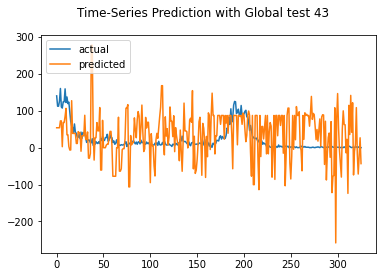

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 53.540
Test RMSE: 61.441
Test sMAPE: 133.019
Test R Squared: -2.475
{'mae': 53.54047193007966, 'rmse': 61.440847482051545, 'smape': 133.01916992442085, 'r2': -2.4745679648999763}


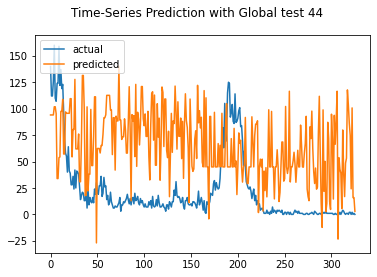

Test MAE: 100.294
Test RMSE: 170.974
Test sMAPE: 138.865
Test R Squared: -25.906
{'mae': 100.2944910341611, 'rmse': 170.9739215931146, 'smape': 138.86452380162842, 'r2': -25.905815665473554}


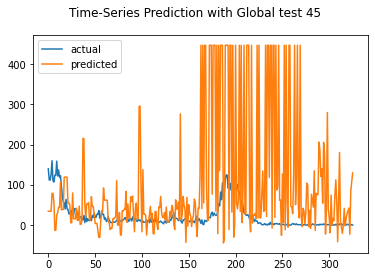

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 44.599
Test RMSE: 54.133
Test sMAPE: 130.692
Test R Squared: -1.697
{'mae': 44.598543396756696, 'rmse': 54.13251817764786, 'smape': 130.69186038403905, 'r2': -1.6971361938216507}


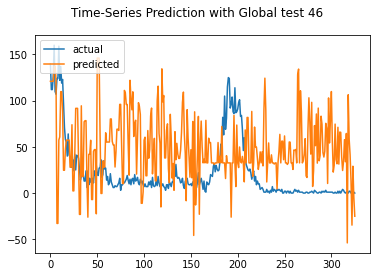

Test MAE: 78.822
Test RMSE: 89.964
Test sMAPE: 156.662
Test R Squared: -6.449
{'mae': 78.82182524101866, 'rmse': 89.96430327858485, 'smape': 156.66192921529276, 'r2': -6.449495430681906}


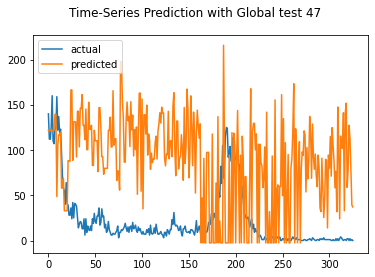

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 51.160
Test RMSE: 57.986
Test sMAPE: 130.788
Test R Squared: -2.095
{'mae': 51.1602927872374, 'rmse': 57.98559173542717, 'smape': 130.7879955849089, 'r2': -2.094757350277902}


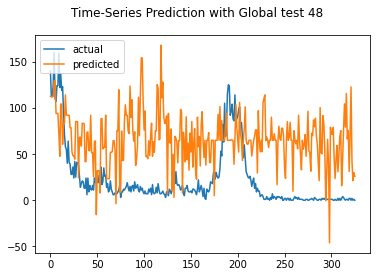

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 47.477
Test RMSE: 57.907
Test sMAPE: 131.064
Test R Squared: -2.086
{'mae': 47.47696883254256, 'rmse': 57.90718554746485, 'smape': 131.0640520887286, 'r2': -2.0863937527398044}


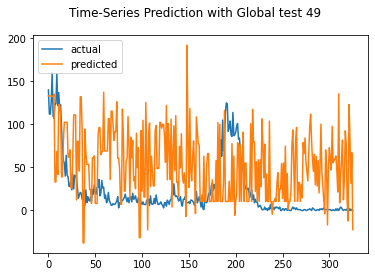

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 61.684
Test RMSE: 69.940
Test sMAPE: 138.015
Test R Squared: -3.502
{'mae': 61.68442682254534, 'rmse': 69.9401881449271, 'smape': 138.0150768679271, 'r2': -3.502357836803351}


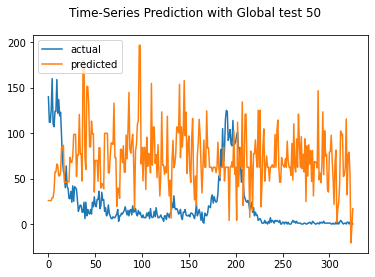

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 55.588
Test RMSE: 64.293
Test sMAPE: 131.408
Test R Squared: -2.805
{'mae': 55.588151380693986, 'rmse': 64.29315606125756, 'smape': 131.40776691645615, 'r2': -2.804660473903497}


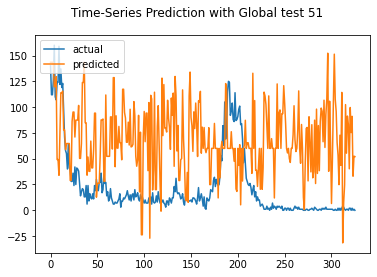

Test MAE: 78.290
Test RMSE: 107.171
Test sMAPE: 137.145
Test R Squared: -9.572
{'mae': 78.28966495202728, 'rmse': 107.17130299430441, 'smape': 137.14510362775292, 'r2': -9.571666107738087}


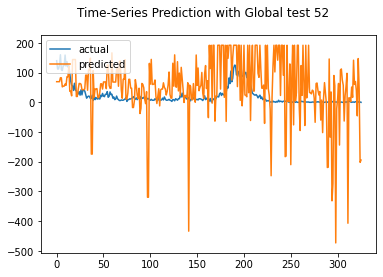

Test MAE: 86.808
Test RMSE: 96.084
Test sMAPE: 156.630
Test R Squared: -7.497
{'mae': 86.80815005741236, 'rmse': 96.08400338460257, 'smape': 156.62959854104335, 'r2': -7.4974495714376275}


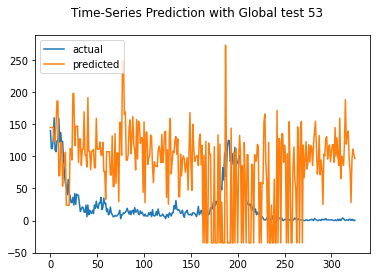

Test MAE: 99.655
Test RMSE: 116.423
Test sMAPE: 161.907
Test R Squared: -11.476
{'mae': 99.65509174718447, 'rmse': 116.42252674782587, 'smape': 161.9066661713757, 'r2': -11.475571728334527}


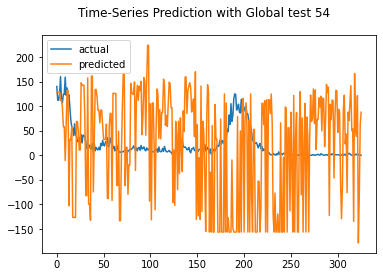

Test MAE: 62.290
Test RMSE: 72.102
Test sMAPE: 136.283
Test R Squared: -3.785
{'mae': 62.290305961494795, 'rmse': 72.10182159057437, 'smape': 136.28345886113877, 'r2': -3.784966373252929}


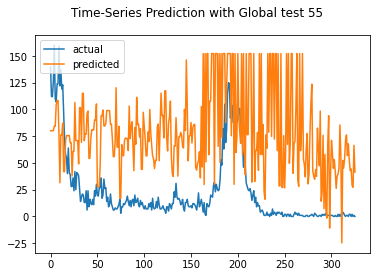

Test MAE: 81.571
Test RMSE: 91.063
Test sMAPE: 154.267
Test R Squared: -6.633
{'mae': 81.57058885931238, 'rmse': 91.06281336008831, 'smape': 154.26697852039595, 'r2': -6.6325304111866155}


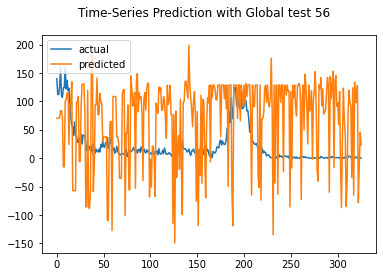

Test MAE: 52.321
Test RMSE: 62.289
Test sMAPE: 131.613
Test R Squared: -2.571
{'mae': 52.3211802825606, 'rmse': 62.289007632959645, 'smape': 131.6134343333832, 'r2': -2.571159436949136}


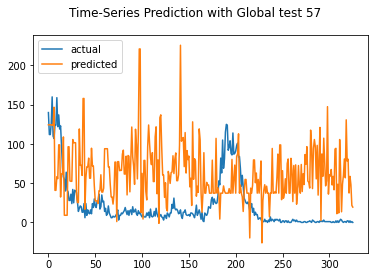

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 61.885
Test RMSE: 74.013
Test sMAPE: 141.456
Test R Squared: -4.042
{'mae': 61.885080376285714, 'rmse': 74.01252457979591, 'smape': 141.4560576615829, 'r2': -4.041930476349876}


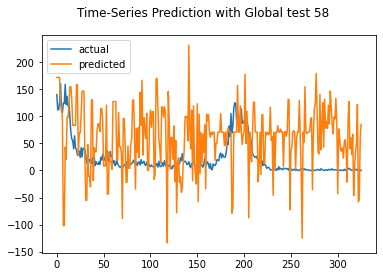

Test MAE: 51.107
Test RMSE: 61.848
Test sMAPE: 146.130
Test R Squared: -2.521
{'mae': 51.107383449750444, 'rmse': 61.84775266487527, 'smape': 146.13011448483405, 'r2': -2.5207425029534214}


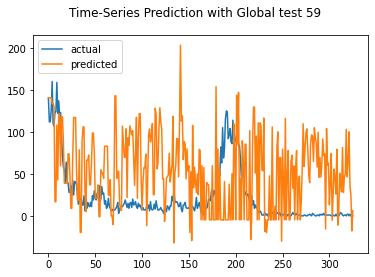

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 60.518
Test RMSE: 76.902
Test sMAPE: 139.244
Test R Squared: -4.443
{'mae': 60.518148007568406, 'rmse': 76.90178383064713, 'smape': 139.24421901281679, 'r2': -4.443262067126196}


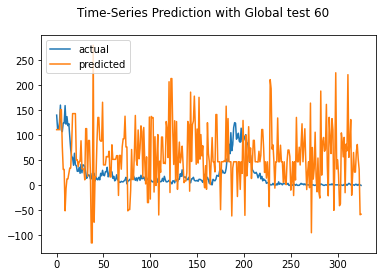

Test MAE: 85.401
Test RMSE: 107.370
Test sMAPE: 152.084
Test R Squared: -9.611
{'mae': 85.40115719777675, 'rmse': 107.37000190932336, 'smape': 152.0842732948638, 'r2': -9.61090283987971}


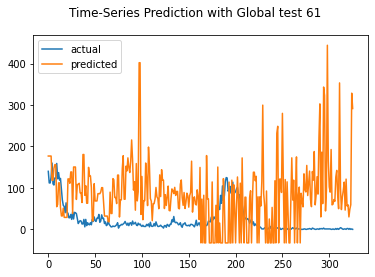

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 55.440
Test RMSE: 69.224
Test sMAPE: 140.236
Test R Squared: -3.411
{'mae': 55.4395958150457, 'rmse': 69.22365917983834, 'smape': 140.23597985310624, 'r2': -3.410578145201324}


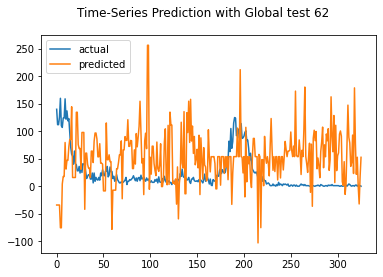

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 50.206
Test RMSE: 62.762
Test sMAPE: 137.972
Test R Squared: -2.626
{'mae': 50.206329395526026, 'rmse': 62.76152177223337, 'smape': 137.9717576641931, 'r2': -2.62554539201452}


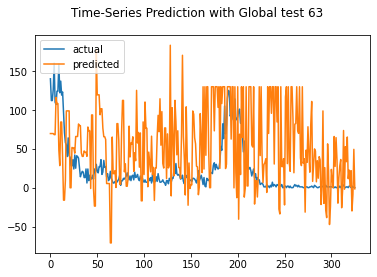

Test MAE: 44.199
Test RMSE: 52.600
Test sMAPE: 137.907
Test R Squared: -1.547
{'mae': 44.199079784330415, 'rmse': 52.60010754516784, 'smape': 137.90732494602136, 'r2': -1.5465938177309995}


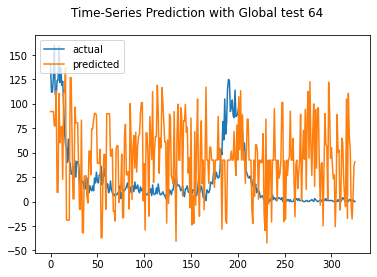

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 60.988
Test RMSE: 69.669
Test sMAPE: 137.468
Test R Squared: -3.468
{'mae': 60.988091324736004, 'rmse': 69.66935066863607, 'smape': 137.46764027465207, 'r2': -3.467555350840523}


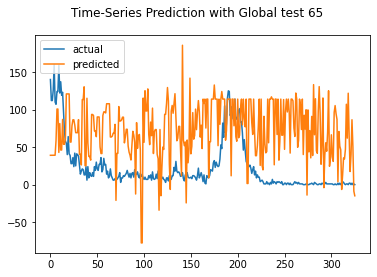

Test MAE: 43.283
Test RMSE: 49.304
Test sMAPE: 128.022
Test R Squared: -1.237
{'mae': 43.283061717734014, 'rmse': 49.30419934934056, 'smape': 128.0221889352275, 'r2': -1.2374546295985671}


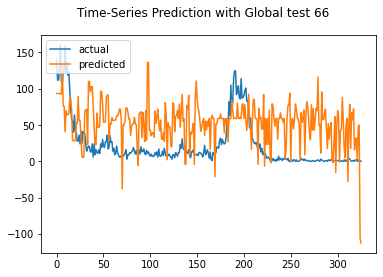

Test MAE: 81.763
Test RMSE: 100.673
Test sMAPE: 143.325
Test R Squared: -8.328
{'mae': 81.76348019578705, 'rmse': 100.67290878270083, 'smape': 143.32453556387208, 'r2': -8.328496443363392}


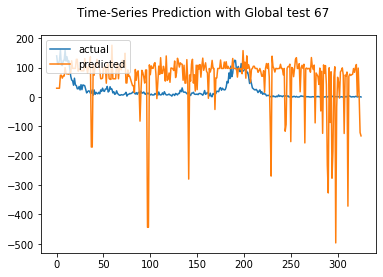

Test MAE: 47.118
Test RMSE: 56.511
Test sMAPE: 126.283
Test R Squared: -1.939
{'mae': 47.11813379504198, 'rmse': 56.51066680341346, 'smape': 126.28314039022483, 'r2': -1.9393227758710552}


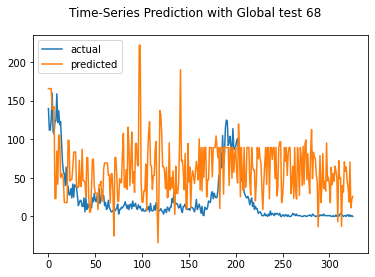

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 45.349
Test RMSE: 59.144
Test sMAPE: 144.305
Test R Squared: -2.220
{'mae': 45.34901724106695, 'rmse': 59.143873752189656, 'smape': 144.30461960966363, 'r2': -2.2196298746318663}


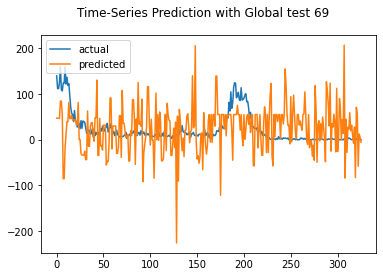

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 45.264
Test RMSE: 54.100
Test sMAPE: 130.459
Test R Squared: -1.694
{'mae': 45.26364532131359, 'rmse': 54.1003733631763, 'smape': 130.45933360596422, 'r2': -1.693933933745238}


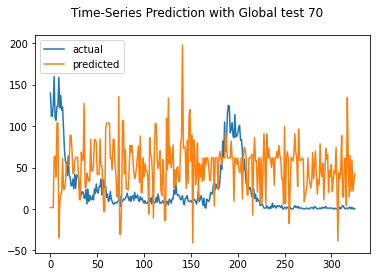

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 48.883
Test RMSE: 56.342
Test sMAPE: 131.456
Test R Squared: -1.922
{'mae': 48.883161448627895, 'rmse': 56.34239015534479, 'smape': 131.45636995691953, 'r2': -1.9218434935684297}


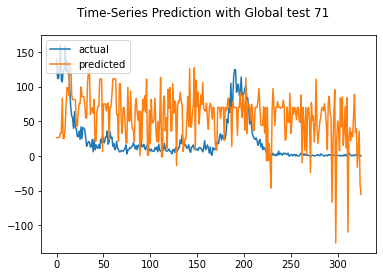

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 50.043
Test RMSE: 60.834
Test sMAPE: 131.743
Test R Squared: -2.406
{'mae': 50.042626019270145, 'rmse': 60.833615463940504, 'smape': 131.74272096338305, 'r2': -2.4062276708437533}


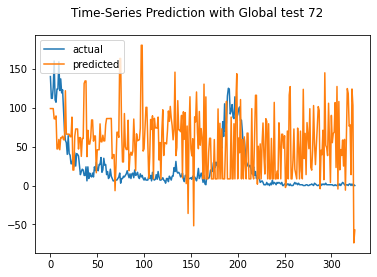

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 54.668
Test RMSE: 65.659
Test sMAPE: 137.858
Test R Squared: -2.968
{'mae': 54.66822224343481, 'rmse': 65.65933842061668, 'smape': 137.8584201803456, 'r2': -2.9680708802081144}


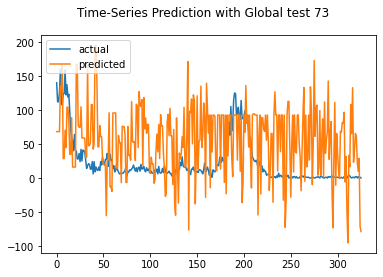

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 51.567
Test RMSE: 60.558
Test sMAPE: 127.358
Test R Squared: -2.375
{'mae': 51.56743350497053, 'rmse': 60.558260427191996, 'smape': 127.35762985220435, 'r2': -2.3754618105322995}


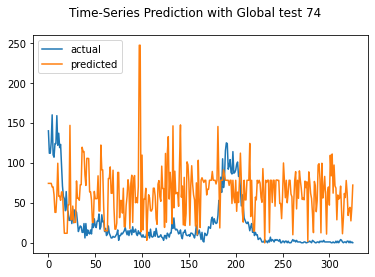

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 49.678
Test RMSE: 61.777
Test sMAPE: 136.247
Test R Squared: -2.513
{'mae': 49.67774910155249, 'rmse': 61.77730124813074, 'smape': 136.24681702685493, 'r2': -2.512726042744709}


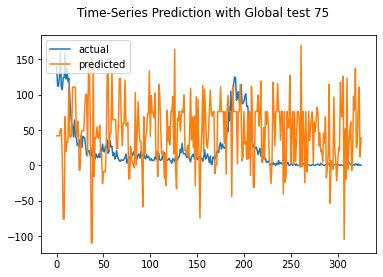

Test MAE: 63.148
Test RMSE: 70.443
Test sMAPE: 141.829
Test R Squared: -3.567
{'mae': 63.14808272547517, 'rmse': 70.44290050905737, 'smape': 141.82937595286086, 'r2': -3.567314061631911}


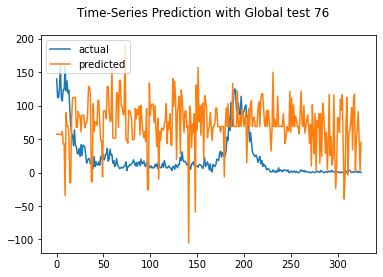

Test MAE: 59.264
Test RMSE: 71.986
Test sMAPE: 133.698
Test R Squared: -3.770
{'mae': 59.263922959017606, 'rmse': 71.98629305901747, 'smape': 133.698217490563, 'r2': -3.769644783549161}


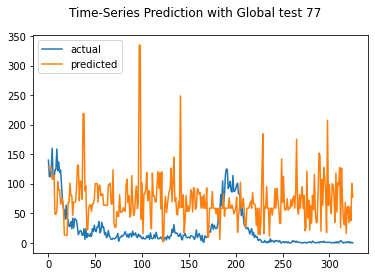

Test MAE: 95.107
Test RMSE: 110.135
Test sMAPE: 149.828
Test R Squared: -10.164
{'mae': 95.10714276875456, 'rmse': 110.13492883758309, 'smape': 149.82844436165496, 'r2': -10.164430313137517}


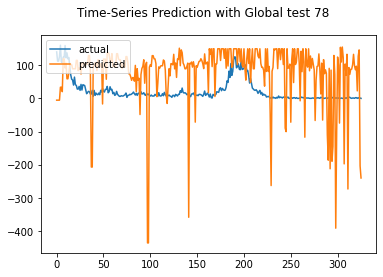

Test MAE: 48.536
Test RMSE: 54.030
Test sMAPE: 132.818
Test R Squared: -1.687
{'mae': 48.535670345729116, 'rmse': 54.030014522467106, 'smape': 132.81762907211052, 'r2': -1.6869314380235343}


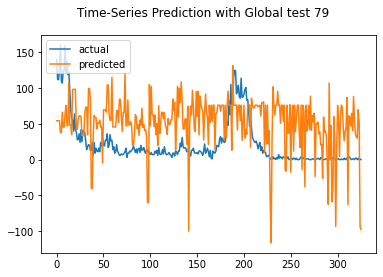

Test MAE: 69.387
Test RMSE: 83.657
Test sMAPE: 154.425
Test R Squared: -5.442
{'mae': 69.38737770622494, 'rmse': 83.6573266836738, 'smape': 154.4253205323159, 'r2': -5.441609310183307}


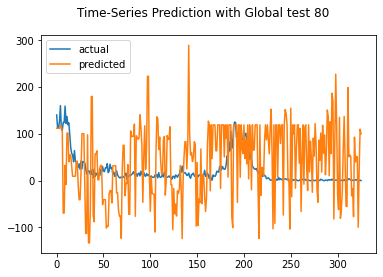

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 54.863
Test RMSE: 70.355
Test sMAPE: 149.833
Test R Squared: -3.556
{'mae': 54.862965517248846, 'rmse': 70.355347751622, 'smape': 149.83310569596347, 'r2': -3.5559677816427318}


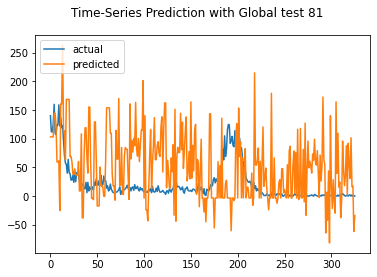

Test MAE: 50.983
Test RMSE: 56.646
Test sMAPE: 132.581
Test R Squared: -1.953
{'mae': 50.982783296539736, 'rmse': 56.64566706021217, 'smape': 132.58086247924606, 'r2': -1.9533832472012103}


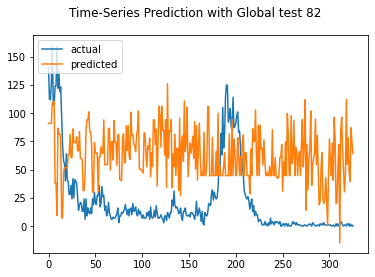

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 50.096
Test RMSE: 56.715
Test sMAPE: 135.490
Test R Squared: -1.961
{'mae': 50.09621021133259, 'rmse': 56.7146115389139, 'smape': 135.49040970780413, 'r2': -1.9605768559430765}


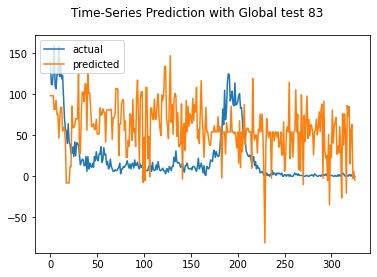

Test MAE: 65.436
Test RMSE: 75.888
Test sMAPE: 147.608
Test R Squared: -4.301
{'mae': 65.43599296859436, 'rmse': 75.88813266590279, 'smape': 147.60752077610192, 'r2': -4.3007112754725965}


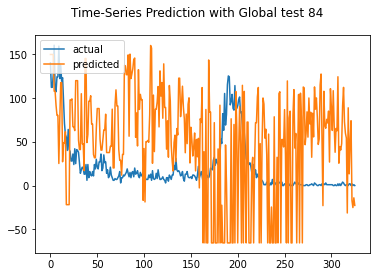

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 40.989
Test RMSE: 52.374
Test sMAPE: 138.361
Test R Squared: -1.525
{'mae': 40.988609238453435, 'rmse': 52.373748235632654, 'smape': 138.3614834385409, 'r2': -1.5247229544236847}


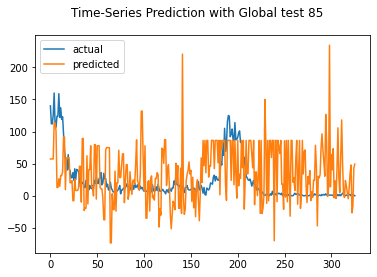

Test MAE: 60.793
Test RMSE: 70.560
Test sMAPE: 151.004
Test R Squared: -3.583
{'mae': 60.79274788480595, 'rmse': 70.56023743636744, 'smape': 151.0043596221011, 'r2': -3.5825423083782493}


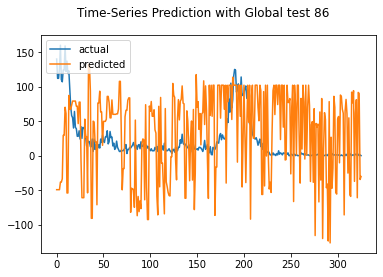

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.414
Test RMSE: 57.471
Test sMAPE: 131.776
Test R Squared: -2.040
{'mae': 47.41428919072531, 'rmse': 57.47101809933928, 'smape': 131.7762143105132, 'r2': -2.0400742978663313}


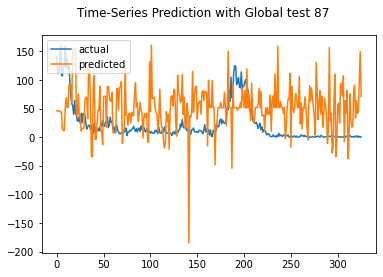

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 46.705
Test RMSE: 57.334
Test sMAPE: 140.994
Test R Squared: -2.026
{'mae': 46.70521186959524, 'rmse': 57.33356841983783, 'smape': 140.99410919067915, 'r2': -2.0255501926468296}


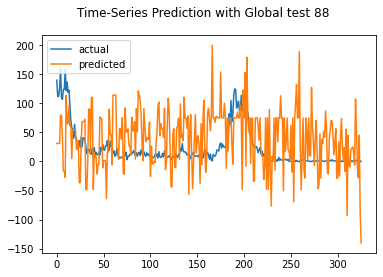

Test MAE: 57.902
Test RMSE: 66.542
Test sMAPE: 150.357
Test R Squared: -3.076
{'mae': 57.90223880048178, 'rmse': 66.54222437985786, 'smape': 150.3566385565559, 'r2': -3.0755013847845394}


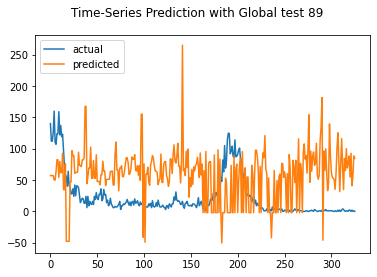

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 59.114
Test RMSE: 67.787
Test sMAPE: 134.956
Test R Squared: -3.229
{'mae': 59.11411840985158, 'rmse': 67.78668056451846, 'smape': 134.95642156595557, 'r2': -3.2293648471165604}


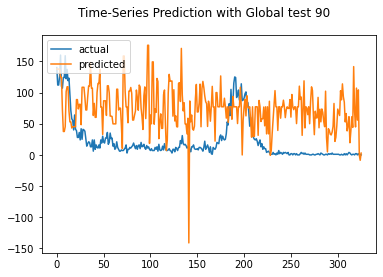

Test MAE: 71.738
Test RMSE: 95.058
Test sMAPE: 173.235
Test R Squared: -7.317
{'mae': 71.7384386239059, 'rmse': 95.05846777856573, 'smape': 173.2348891166192, 'r2': -7.31702555100531}


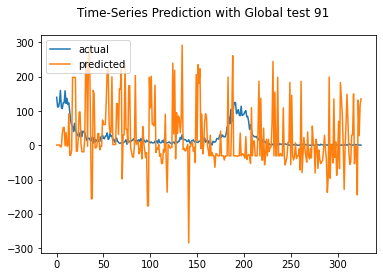

Test MAE: 60.991
Test RMSE: 80.071
Test sMAPE: 139.001
Test R Squared: -4.901
{'mae': 60.990915588623174, 'rmse': 80.07084670443186, 'smape': 139.0009376390427, 'r2': -4.901131032762614}


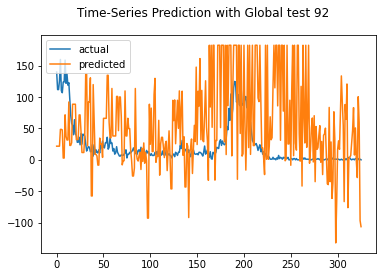

Test MAE: 57.035
Test RMSE: 67.401
Test sMAPE: 134.727
Test R Squared: -3.181
{'mae': 57.03484726957748, 'rmse': 67.40126482162131, 'smape': 134.7265712447529, 'r2': -3.1814076454374822}


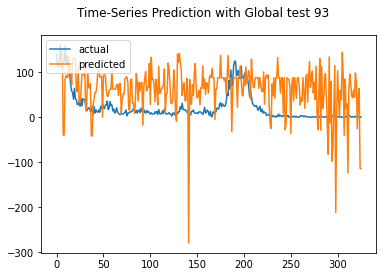

Test MAE: 87.615
Test RMSE: 103.258
Test sMAPE: 152.933
Test R Squared: -8.814
{'mae': 87.61475131848107, 'rmse': 103.25798971499327, 'smape': 152.9328787596396, 'r2': -8.813721917645813}


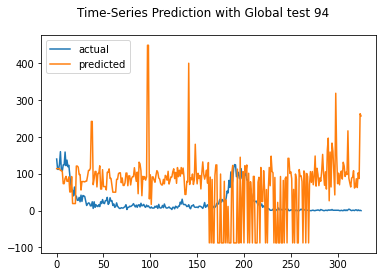

Test MAE: 156.183
Test RMSE: 167.943
Test sMAPE: 169.575
Test R Squared: -24.960
{'mae': 156.18313490101164, 'rmse': 167.94295681043073, 'smape': 169.57485650332603, 'r2': -24.960317905776282}


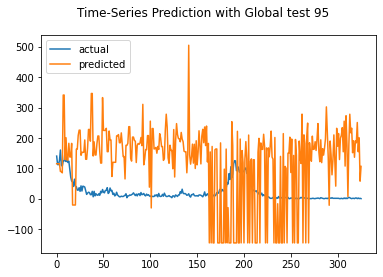

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 62.874
Test RMSE: 76.904
Test sMAPE: 138.755
Test R Squared: -4.444
{'mae': 62.87438067263621, 'rmse': 76.90393493320838, 'smape': 138.75506092147273, 'r2': -4.44356659006841}


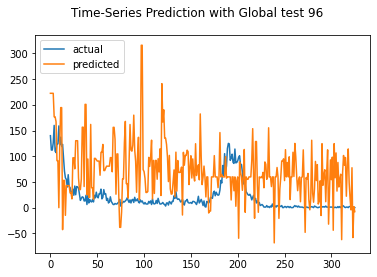

Test MAE: 48.917
Test RMSE: 57.265
Test sMAPE: 130.226
Test R Squared: -2.018
{'mae': 48.916539641611415, 'rmse': 57.26518918696007, 'smape': 130.226050884168, 'r2': -2.018337614197945}


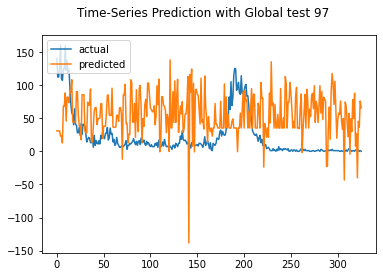

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 45.929
Test RMSE: 55.388
Test sMAPE: 128.935
Test R Squared: -1.824
{'mae': 45.92916880776546, 'rmse': 55.388081008246274, 'smape': 128.93536614034474, 'r2': -1.8237032496672518}


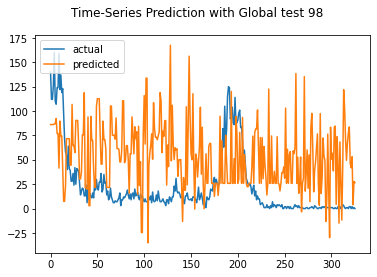

Test MAE: 66.959
Test RMSE: 103.821
Test sMAPE: 139.112
Test R Squared: -8.921
{'mae': 66.95914907058689, 'rmse': 103.82122821541697, 'smape': 139.11226075205414, 'r2': -8.921075184734674}


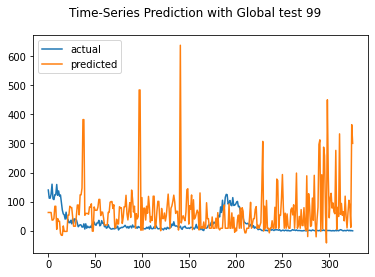

rmse : average=74.879, std=23.951
mae : average=61.177, std=18.654
smape : average=140.562, std=10.241
r2 : average=-4.689, std=4.345


([74.87913368056314, 23.95068781057185],
 [61.17699298638507, 18.654352870842274],
 [140.56213122514737, 10.241376296701713],
 [-4.688679153729813, 4.345116709370484])

In [12]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
